# Phase 0: Data Split & Temporal Hygiene

## Objectives
1. Load and parse P2P transactions data
2. Sort transactions by timestamp
3. Create time-based train/validation split (last 20% = validation)
4. Implement anti-leakage framework for temporal features
5. Validate data quality and fraud distribution

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
plt.style.use('default')
sns.set_palette('husl')

print("Libraries loaded successfully!")

Matplotlib is building the font cache; this may take a moment.


Libraries loaded successfully!


## 1. Load P2P Transactions Data

In [2]:
# Load the main P2P transactions dataset
data_path = Path('data')
p2p_df = pd.read_csv(data_path / 'p2p_transactions.csv')

print(f"Loaded {len(p2p_df):,} P2P transactions")
print(f"Columns: {list(p2p_df.columns)}")
print(f"Shape: {p2p_df.shape}")

# Display first few rows
p2p_df.head()

Loaded 70,000 P2P transactions
Columns: ['p2p_id', 'timestamp', 'sender_account_id', 'receiver_account_id', 'amount', 'currency', 'is_fraud_truth', 'is_fraud']
Shape: (70000, 8)


,p2p_id,timestamp,sender_account_id,receiver_account_id,amount,currency,is_fraud_truth,is_fraud
0,f085a224-e1e7-4dc2-9088-f7479f5af0a4,2025-03-04 15:50:00+00:00,AC0053,AC0894,617.73,CHF,0,0
1,fa1050a8-4231-42a1-840a-7b61c3e56f02,2025-05-16 09:08:01+00:00,AC2488,AC1926,19.04,CHF,0,0
2,fed43073-00a5-4bb9-8441-e339bad42032,2025-03-15 20:31:27+00:00,AC1159,AC2284,2376.63,CHF,0,0
3,998018d0-4720-4ce0-9d46-4e27715d2928,2025-05-16 13:29:27+00:00,AC0319,AC1201,19.27,CHF,0,0
4,9dc3cd82-473a-4e96-8706-ce9f7fc440b5,2025-05-23 15:30:58+00:00,AC0184,AC1063,1655.90,CHF,0,0


In [3]:
# Check data types and missing values
print("Data Types:")
print(p2p_df.dtypes)
print("\nMissing Values:")
print(p2p_df.isnull().sum())
print("\nBasic Statistics:")
p2p_df.describe()

Data Types:
p2p_id                  object
timestamp               object
sender_account_id       object
receiver_account_id     object
amount                 float64
currency                object
is_fraud_truth           int64
is_fraud                 int64
dtype: object

Missing Values:
p2p_id                 0
timestamp              0
sender_account_id      0
receiver_account_id    0
amount                 0
currency               0
is_fraud_truth         0
is_fraud               0
dtype: int64

Basic Statistics:


,amount,is_fraud_truth,is_fraud
count,70000.000000,70000.000000,70000.000000
mean,442.789418,0.016071,0.018200
std,747.134592,0.125751,0.133675
min,0.100000,0.000000,0.000000
25%,18.960000,0.000000,0.000000
50%,97.760000,0.000000,0.000000
75%,569.805000,0.000000,0.000000
max,4999.850000,1.000000,1.000000


## 2. Parse Timestamps and Sort Data

In [4]:
# Parse timestamp column
p2p_df['timestamp'] = pd.to_datetime(p2p_df['timestamp'])

# Sort by timestamp - CRITICAL for temporal validation
p2p_df = p2p_df.sort_values('timestamp').reset_index(drop=True)

print(f"Date range: {p2p_df['timestamp'].min()} to {p2p_df['timestamp'].max()}")
print(f"Time span: {(p2p_df['timestamp'].max() - p2p_df['timestamp'].min()).days} days")

# Check if data is properly sorted
print(f"\nFirst 5 timestamps:")
print(p2p_df['timestamp'].head())
print(f"\nLast 5 timestamps:")
print(p2p_df['timestamp'].tail())

Date range: 2025-03-01 00:08:51+00:00 to 2025-05-31 23:58:56+00:00
Time span: 91 days

First 5 timestamps:
0   2025-03-01 00:08:51+00:00
1   2025-03-01 00:46:25+00:00
2   2025-03-01 00:52:48+00:00
3   2025-03-01 02:12:00+00:00
4   2025-03-01 03:20:54+00:00
Name: timestamp, dtype: datetime64[ns, UTC]

Last 5 timestamps:
69995   2025-05-31 23:53:51+00:00
69996   2025-05-31 23:54:28+00:00
69997   2025-05-31 23:58:23+00:00
69998   2025-05-31 23:58:36+00:00
69999   2025-05-31 23:58:56+00:00
Name: timestamp, dtype: datetime64[ns, UTC]


## 3. Fraud Distribution Analysis

In [5]:
# Analyze fraud distribution
print("Fraud Distribution (is_fraud - noisy labels):")
fraud_dist = p2p_df['is_fraud'].value_counts()
print(fraud_dist)
print(f"Fraud rate: {fraud_dist[1] / len(p2p_df) * 100:.2f}%")

print("\nGround Truth Distribution (is_fraud_truth - clean labels):")
truth_dist = p2p_df['is_fraud_truth'].value_counts()
print(truth_dist)
print(f"True fraud rate: {truth_dist[1] / len(p2p_df) * 100:.2f}%")

# Compare noisy vs clean labels
label_comparison = pd.crosstab(p2p_df['is_fraud'], p2p_df['is_fraud_truth'], 
                              margins=True, margins_name='Total')
print("\nLabel Comparison (noisy vs truth):")
print(label_comparison)

Fraud Distribution (is_fraud - noisy labels):
is_fraud
0    68726
1     1274
Name: count, dtype: int64
Fraud rate: 1.82%

Ground Truth Distribution (is_fraud_truth - clean labels):
is_fraud_truth
0    68875
1     1125
Name: count, dtype: int64
True fraud rate: 1.61%

Label Comparison (noisy vs truth):
is_fraud_truth      0     1  Total
is_fraud                          
0               68705    21  68726
1                 170  1104   1274
Total           68875  1125  70000


## 4. Time-Based Train/Validation Split

In [6]:
# Calculate split point - last 20% by timestamp = validation
total_transactions = len(p2p_df)
train_size = int(0.8 * total_transactions)
split_timestamp = p2p_df.iloc[train_size]['timestamp']

print(f"Total transactions: {total_transactions:,}")
print(f"Train size: {train_size:,} (80%)")
print(f"Validation size: {total_transactions - train_size:,} (20%)")
print(f"Split timestamp: {split_timestamp}")

# Create train/validation sets
train_df = p2p_df.iloc[:train_size].copy()
val_df = p2p_df.iloc[train_size:].copy()

print(f"\nTrain period: {train_df['timestamp'].min()} to {train_df['timestamp'].max()}")
print(f"Validation period: {val_df['timestamp'].min()} to {val_df['timestamp'].max()}")

# Verify no temporal overlap
assert train_df['timestamp'].max() <= val_df['timestamp'].min(), "ERROR: Temporal overlap detected!"
print("\n✅ Temporal split validated - no leakage!")

Total transactions: 70,000
Train size: 56,000 (80%)
Validation size: 14,000 (20%)
Split timestamp: 2025-05-14 15:18:44+00:00

Train period: 2025-03-01 00:08:51+00:00 to 2025-05-14 15:14:17+00:00
Validation period: 2025-05-14 15:18:44+00:00 to 2025-05-31 23:58:56+00:00

✅ Temporal split validated - no leakage!


Fraud distribution in splits:

Train fraud rate: 1.87%
Validation fraud rate: 1.62%

Train truth fraud rate: 1.65%
Validation truth fraud rate: 1.44%


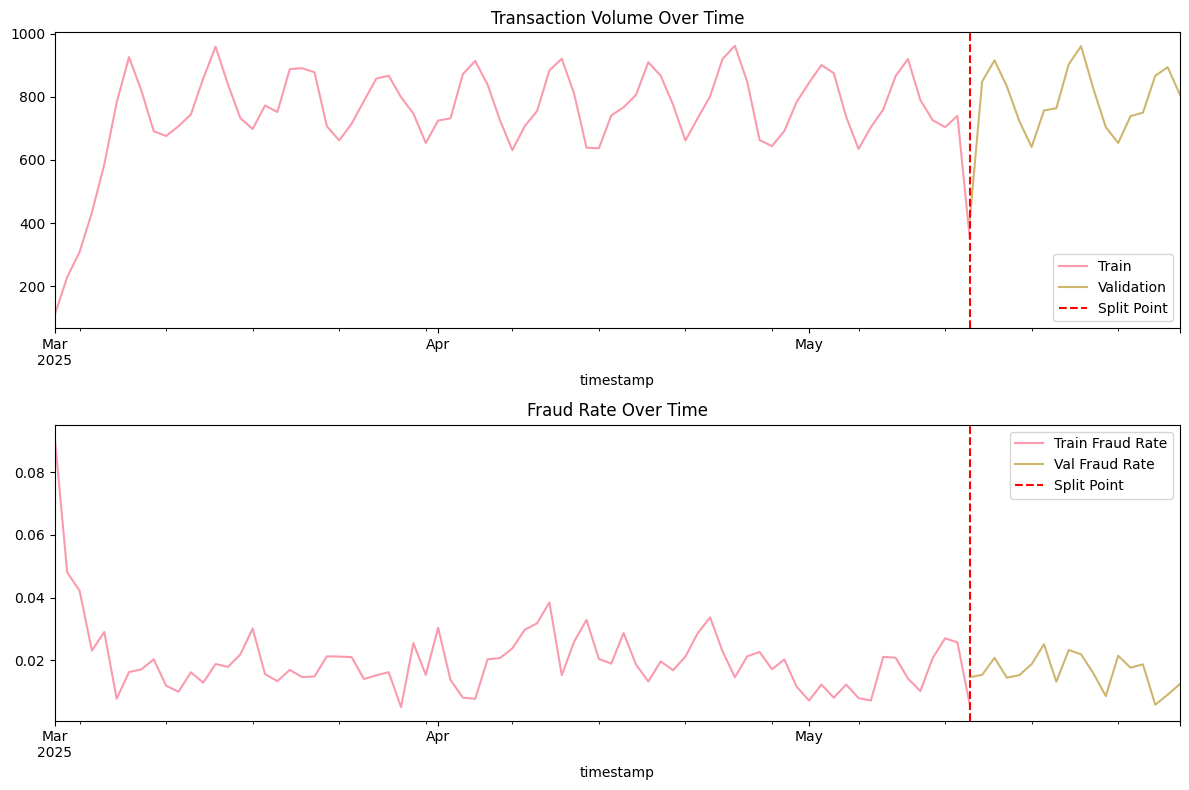

In [7]:
# Check fraud distribution in train/validation splits
print("Fraud distribution in splits:")
print(f"\nTrain fraud rate: {train_df['is_fraud'].mean() * 100:.2f}%")
print(f"Validation fraud rate: {val_df['is_fraud'].mean() * 100:.2f}%")

print(f"\nTrain truth fraud rate: {train_df['is_fraud_truth'].mean() * 100:.2f}%")
print(f"Validation truth fraud rate: {val_df['is_fraud_truth'].mean() * 100:.2f}%")

# Create a visualization
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Transaction volume over time
train_df.set_index('timestamp').resample('D').size().plot(ax=axes[0], label='Train', alpha=0.7)
val_df.set_index('timestamp').resample('D').size().plot(ax=axes[0], label='Validation', alpha=0.7)
axes[0].axvline(split_timestamp, color='red', linestyle='--', label='Split Point')
axes[0].set_title('Transaction Volume Over Time')
axes[0].legend()

# Fraud rate over time
train_fraud_rate = train_df.set_index('timestamp').resample('D')['is_fraud'].mean()
val_fraud_rate = val_df.set_index('timestamp').resample('D')['is_fraud'].mean()
train_fraud_rate.plot(ax=axes[1], label='Train Fraud Rate', alpha=0.7)
val_fraud_rate.plot(ax=axes[1], label='Val Fraud Rate', alpha=0.7)
axes[1].axvline(split_timestamp, color='red', linestyle='--', label='Split Point')
axes[1].set_title('Fraud Rate Over Time')
axes[1].legend()

plt.tight_layout()
plt.show()

## 5. Anti-Leakage Framework Setup

In [8]:
# Create a class to handle temporal feature engineering without leakage
class TemporalFeatureEngineer:
    def __init__(self):
        self.fitted_stats = {}
        self.split_timestamp = None
    
    def fit(self, train_df, split_timestamp):
        """Fit on training data only"""
        self.split_timestamp = split_timestamp
        
        # Store training statistics for z-score normalization
        self.fitted_stats['amount_mean'] = train_df['amount'].mean()
        self.fitted_stats['amount_std'] = train_df['amount'].std()
        
        # Store sender/receiver statistics
        sender_stats = train_df.groupby('sender_account_id')['amount'].agg(['mean', 'std'])
        receiver_stats = train_df.groupby('receiver_account_id')['amount'].agg(['mean', 'std'])
        
        self.fitted_stats['sender_amount_mean'] = sender_stats['mean'].to_dict()
        self.fitted_stats['sender_amount_std'] = sender_stats['std'].to_dict()
        self.fitted_stats['receiver_amount_mean'] = receiver_stats['mean'].to_dict()
        self.fitted_stats['receiver_amount_std'] = receiver_stats['std'].to_dict()
        
        print(f"✅ Fitted temporal feature engineer on {len(train_df):,} training samples")
        return self
    
    def transform(self, df, is_validation=False):
        """Transform features ensuring no future data leakage"""
        if self.split_timestamp is None:
            raise ValueError("Must fit() before transform()")
        
        df_features = df.copy()
        
        # Basic amount features
        df_features['amount_log1p'] = np.log1p(df_features['amount'])
        df_features['amount_zscore'] = (df_features['amount'] - self.fitted_stats['amount_mean']) / self.fitted_stats['amount_std']
        
        # Sender/receiver amount z-scores (using training stats)
        df_features['sender_amount_zscore'] = df_features.apply(
            lambda row: (row['amount'] - self.fitted_stats['sender_amount_mean'].get(row['sender_account_id'], self.fitted_stats['amount_mean'])) / 
                        max(self.fitted_stats['sender_amount_std'].get(row['sender_account_id'], self.fitted_stats['amount_std']), 1e-8),
            axis=1
        )
        
        df_features['receiver_amount_zscore'] = df_features.apply(
            lambda row: (row['amount'] - self.fitted_stats['receiver_amount_mean'].get(row['receiver_account_id'], self.fitted_stats['amount_mean'])) / 
                        max(self.fitted_stats['receiver_amount_std'].get(row['receiver_account_id'], self.fitted_stats['amount_std']), 1e-8),
            axis=1
        )
        
        print(f"✅ Transformed {len(df_features):,} samples ({'validation' if is_validation else 'training'})")
        return df_features
    
    def fit_transform(self, train_df, split_timestamp):
        """Fit and transform training data"""
        return self.fit(train_df, split_timestamp).transform(train_df, is_validation=False)

# Test the feature engineer
feature_engineer = TemporalFeatureEngineer()
train_features = feature_engineer.fit_transform(train_df, split_timestamp)
val_features = feature_engineer.transform(val_df, is_validation=True)

print(f"\nTraining features shape: {train_features.shape}")
print(f"Validation features shape: {val_features.shape}")
print(f"New feature columns: {[col for col in train_features.columns if col not in p2p_df.columns]}")

✅ Fitted temporal feature engineer on 56,000 training samples
✅ Transformed 56,000 samples (training)
✅ Transformed 14,000 samples (validation)

Training features shape: (56000, 12)
Validation features shape: (14000, 12)
New feature columns: ['amount_log1p', 'amount_zscore', 'sender_amount_zscore', 'receiver_amount_zscore']


## 6. Data Quality Validation

Currency distribution:
currency
CHF    70000
Name: count, dtype: int64

Account Analysis:
Unique senders: 1,803
Unique receivers: 1,741
Total unique accounts: 1,806

Transaction Amount Statistics:
Min: 0.10 CHF
Max: 4999.85 CHF
Mean: 442.79 CHF
Median: 97.76 CHF


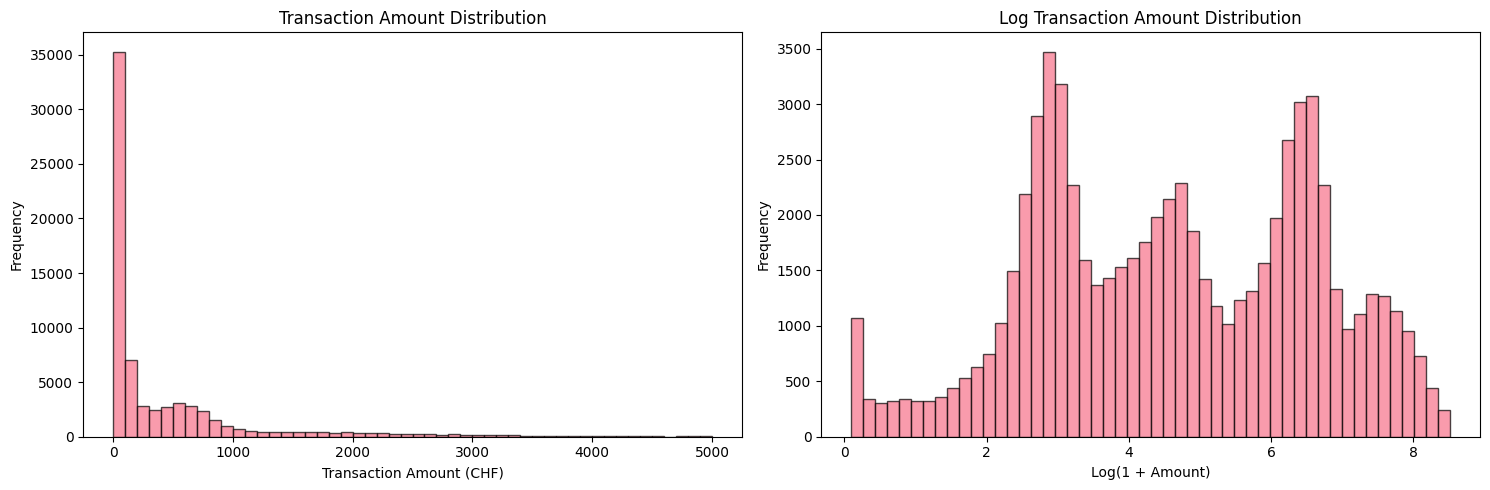

In [9]:
# Currency distribution
print("Currency distribution:")
print(p2p_df['currency'].value_counts())

# Unique accounts analysis
unique_senders = p2p_df['sender_account_id'].nunique()
unique_receivers = p2p_df['receiver_account_id'].nunique()
all_accounts = set(p2p_df['sender_account_id']) | set(p2p_df['receiver_account_id'])
total_unique_accounts = len(all_accounts)

print(f"\nAccount Analysis:")
print(f"Unique senders: {unique_senders:,}")
print(f"Unique receivers: {unique_receivers:,}")
print(f"Total unique accounts: {total_unique_accounts:,}")

# Transaction amount distribution
print(f"\nTransaction Amount Statistics:")
print(f"Min: {p2p_df['amount'].min():.2f} CHF")
print(f"Max: {p2p_df['amount'].max():.2f} CHF")
print(f"Mean: {p2p_df['amount'].mean():.2f} CHF")
print(f"Median: {p2p_df['amount'].median():.2f} CHF")

# Visualize amount distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Amount histogram
axes[0].hist(p2p_df['amount'], bins=50, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Transaction Amount (CHF)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Transaction Amount Distribution')

# Log amount histogram
axes[1].hist(np.log1p(p2p_df['amount']), bins=50, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Log(1 + Amount)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Log Transaction Amount Distribution')

plt.tight_layout()
plt.show()

## 7. Save Processed Data

In [10]:
# Save the split data and metadata
output_path = Path('processed_data')
output_path.mkdir(exist_ok=True)

# Save train/validation splits
train_features.to_csv(output_path / 'train_features.csv', index=False)
val_features.to_csv(output_path / 'val_features.csv', index=False)

# Save metadata
metadata = {
    'total_transactions': total_transactions,
    'train_size': len(train_features),
    'val_size': len(val_features),
    'split_timestamp': str(split_timestamp),
    'train_fraud_rate': float(train_features['is_fraud'].mean()),
    'val_fraud_rate': float(val_features['is_fraud'].mean()),
    'unique_accounts': total_unique_accounts,
    'date_range': {
        'start': str(p2p_df['timestamp'].min()),
        'end': str(p2p_df['timestamp'].max())
    }
}

import json
with open(output_path / 'split_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✅ Phase 0 completed successfully!")
print(f"📁 Processed data saved to: {output_path}")
print(f"📊 Ready for Phase 1: Feature Engineering")

# Summary
print(f"\n📋 Phase 0 Summary:")
print(f"• Loaded {total_transactions:,} P2P transactions")
print(f"• Created temporal split: {len(train_features):,} train, {len(val_features):,} validation")
print(f"• Split timestamp: {split_timestamp}")
print(f"• Anti-leakage framework implemented ✅")
print(f"• Baseline features created: amount, log1p, z-scores")
print(f"• Data quality validated ✅")

✅ Phase 0 completed successfully!
📁 Processed data saved to: processed_data
📊 Ready for Phase 1: Feature Engineering

📋 Phase 0 Summary:
• Loaded 70,000 P2P transactions
• Created temporal split: 56,000 train, 14,000 validation
• Split timestamp: 2025-05-14 15:18:44+00:00
• Anti-leakage framework implemented ✅
• Baseline features created: amount, log1p, z-scores
• Data quality validated ✅
